In [2]:
import pandas as pd
import os

def convert_unique_id_to_model_name(unique_id_str):
    if '_' not in unique_id_str:
        return None
    
    parts = unique_id_str.rpartition('_')
    if parts[1] == '_':
        model_name = parts[0] + parts[1] + parts[2].lower()
        return model_name
    else: 
        return unique_id_str.lower() 

def calculate_binding_changes(input_variants_csv_path, af3_summary_csv_path, output_csv_path):
    
    variants_df = pd.read_csv(input_variants_csv_path)
    af3_scores_df = pd.read_csv(af3_summary_csv_path)


    af3_scores_df = af3_scores_df.set_index('model_name', drop=False) 

    results = []
    ref_variants_df = variants_df[variants_df['unique_id'].str.contains('_ref_', case=False, na=False)].copy()

    print(f"Found {len(ref_variants_df)} reference variants to process.")

    for _, ref_row in ref_variants_df.iterrows():
        ref_unique_id = ref_row['unique_id']
        rs_id = ref_row['rs_id']
        tf_gene = ref_row['tf_gene']

        if '_REF_' in ref_unique_id:
            alt_unique_id = ref_unique_id.replace('_REF_', '_ALT_', 1)
        elif '_ref_' in ref_unique_id:
            alt_unique_id = ref_unique_id.replace('_ref_', '_alt_', 1)
        else:
            print(f"Bad format for '{ref_unique_id}'. Skipping.")
            continue

        model_name_ref = convert_unique_id_to_model_name(ref_unique_id)
        model_name_alt = convert_unique_id_to_model_name(alt_unique_id)

        if not model_name_ref or not model_name_alt:
            print(f"No '{ref_unique_id}' or '{alt_unique_id}'. Skipping.")
            continue

        try:
            ref_scores = af3_scores_df.loc[model_name_ref]
            alt_scores = af3_scores_df.loc[model_name_alt]
        except:
            print(f"Not found in AlphaFold3 summary csv. Skipping comparison for {rs_id} ({tf_gene}).")
            continue
        
        ref_iptm = ref_scores.get('interface_chains_0_1_iptm', pd.NA)
        alt_iptm = alt_scores.get('interface_chains_0_1_iptm', pd.NA)
        
        ref_pae_min = ref_scores.get('interface_chains_0_1_pae_min', pd.NA)
        alt_pae_min = alt_scores.get('interface_chains_0_1_pae_min', pd.NA)


        delta_iptm = pd.to_numeric(ref_iptm, errors='coerce') - pd.to_numeric(alt_iptm, errors='coerce')
        delta_pae_min = pd.to_numeric(ref_pae_min, errors='coerce') - pd.to_numeric(alt_pae_min, errors='coerce')
        
        results.append({
            'unique_id': ref_unique_id, 
            'tf': tf_gene,
            'snp': rs_id,
            'delta_interface_iptm': delta_iptm,
            'delta_interface_pae_min': delta_pae_min,
            'ref_iptm': ref_iptm, 
            'alt_iptm': alt_iptm, 
            'ref_pae_min': ref_pae_min, 
            'alt_pae_min': alt_pae_min 
        })

    if not results:
        print("No results to save. Output CSV will not be created.")
        return

    output_df = pd.DataFrame(results)
    
    try:
        output_df.to_csv(output_csv_path, index=False)
        print(f"Successfully created comparison CSV: {output_csv_path}")
    except Exception as e:
        print(f"Error writing output CSV: {e}")

In [5]:
user_variants_csv = 'alpha-factor_tf-seq-pairs_complete.csv'
alphafold3_summary_csv = 'alphafold3_2chain_combined_summary.csv'

output_csv = 'binding_changes_summary.csv'
calculate_binding_changes(user_variants_csv, alphafold3_summary_csv, output_csv)

Found 314 reference variants to process.
Not found in AlphaFold3 summary csv. Skipping comparison for rs4912534 (ATF2+ATF4).
Not found in AlphaFold3 summary csv. Skipping comparison for rs9795476 (ATF2+ATF4).
Successfully created comparison CSV: binding_changes_summary.csv


In [3]:
def create_consolidated_df(variants_csv_path, summary_csv_path):

    variants_df = pd.read_csv(variants_csv_path)
    af3_scores_df = pd.read_csv(summary_csv_path)

        
    af3_scores_df = af3_scores_df.set_index('model_name', drop=False)

    consolidated_data = []
    
    score_columns = af3_scores_df.columns

    for _, row in variants_df.iterrows():
        unique_id = row.get('unique_id')
        snp_id = row.get('rs_id')
        
        if pd.isna(unique_id) or pd.isna(snp_id):
            continue 

        allele_type = 'unknown'
        if '_ref_' in str(unique_id).lower():
            allele_type = 'ref'
        elif '_alt_' in str(unique_id).lower():
            allele_type = 'alt'
            
        model_name = convert_unique_id_to_model_name(unique_id)

        if model_name in af3_scores_df.index:
            scores_series = af3_scores_df.loc[model_name]
            
            entry = {
                'snp': snp_id,
                'unique_id': unique_id,
                'allele_type': allele_type
            }
            for col in score_columns:
                entry[col] = scores_series.get(col, pd.NA)
            
            consolidated_data.append(entry)

    final_df = pd.DataFrame(consolidated_data)
    
    return final_df

In [35]:
path_to_variants_csv = 'alpha-factor_tf-seq-pairs_complete.csv'
path_to_summary_csv = 'alphafold3_2chain_combined_summary.csv'
full_df = create_consolidated_df(path_to_variants_csv, path_to_summary_csv)
ref_df = full_df[full_df['allele_type'] == 'ref'].copy()
alt_df = full_df[full_df['allele_type'] == 'alt'].copy()

In [36]:
full_df

,snp,unique_id,allele_type,model_name,ranking_score,ptm,iptm,interface_chains_0_1_iptm,interface_chains_0_1_pae_min,chain_0_ptm,chain_1_ptm,fraction_disordered,has_clash
0,rs9260130,main_rs9260130_ref_EGR4,ref,main_rs9260130_ref_egr4,0.67,0.24,0.24,0.24,3.21,0.23,0.16,0.86,0.0
1,rs9260130,main_rs9260130_alt_EGR4,alt,main_rs9260130_alt_egr4,0.48,0.25,0.25,0.25,2.65,0.24,0.16,0.47,0.0
2,rs11543947,main_rs11543947_ref_PURA,ref,main_rs11543947_ref_pura,0.34,0.39,0.07,0.07,23.96,0.52,0.13,0.40,0.0
3,rs11543947,main_rs11543947_alt_PURA,alt,main_rs11543947_alt_pura,0.33,0.39,0.07,0.07,23.09,0.51,0.13,0.40,0.0
4,rs148075100,main_rs148075100_ref_PAX8,ref,main_rs148075100_ref_pax8,0.50,0.24,0.11,0.11,20.50,0.26,0.16,0.74,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,rs28367690,main_rs28367690_alt_TFAP2B,alt,main_rs28367690_alt_tfap2b,0.42,0.42,0.10,0.10,24.81,0.52,0.15,0.51,0.0
620,rs28367690,main_rs28367690_ref_TFAP2C,ref,main_rs28367690_ref_tfap2c,0.44,0.41,0.13,0.13,21.26,0.50,0.15,0.52,0.0
621,rs28367690,main_rs28367690_alt_TFAP2C,alt,main_rs28367690_alt_tfap2c,0.43,0.41,0.12,0.12,20.41,0.50,0.15,0.51,0.0
622,rs9267084,main_rs9267084_ref_REST,ref,main_rs9267084_ref_rest,0.24,0.23,0.15,0.15,24.39,0.23,0.14,0.15,0.0


In [37]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os

def plot_metric_distributions(ref_df, alt_df, metric_column, output_dir="metric_plots"):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)


    ref_metric_data = ref_df[metric_column].dropna()
    alt_metric_data = alt_df[metric_column].dropna()

    
    combined_data = pd.concat([ref_metric_data, alt_metric_data])
    combined_data_finite = combined_data[np.isfinite(combined_data)]

    min_val = combined_data_finite.min()
    max_val = combined_data_finite.max()
    
    if min_val == max_val:
        min_val -= 0.5
        max_val += 0.5
    elif max_val - min_val < 1e-6: # Very small range
        min_val -= (abs(min_val) * 0.1) if abs(min_val) > 1e-6 else 0.1
        max_val += (abs(max_val) * 0.1) if abs(max_val) > 1e-6 else 0.1


    fig, ax = plt.subplots(figsize=(10, 6)) 
    fig.suptitle(f'Distribution of {metric_column} (Ref vs. Alt)', fontsize=16)


    if not ref_metric_data.empty:
        sns.histplot(ref_metric_data, kde=True, ax=ax, color='skyblue', bins=20,alpha=0.6, label='Reference Allele')

    if not alt_metric_data.empty:
        sns.histplot(alt_metric_data, kde=True, ax=ax, color='salmon', bins=20,alpha=0.6, label='Alternative Allele')

    ax.set_xlabel(metric_column)
    ax.set_ylabel("Density")
    ax.set_xlim(min_val, max_val)
    ax.legend(title="Allele Type", loc="upper right")
    ax.grid(True)
    ax.grid(color='gray', alpha=0.6, linewidth=0.5)


    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    
    filename_metric = metric_column.replace('[', '').replace(']', '').replace(' ', '_')
    plot_filename = os.path.join(output_dir, f"distribution_{filename_metric}_ref_vs_alt.png")
    plt.savefig(plot_filename)
    print(f"Saved plot at {plot_filename}")



Saved plot at metrics_temp/distribution_interface_chains_0_1_iptm_ref_vs_alt.png


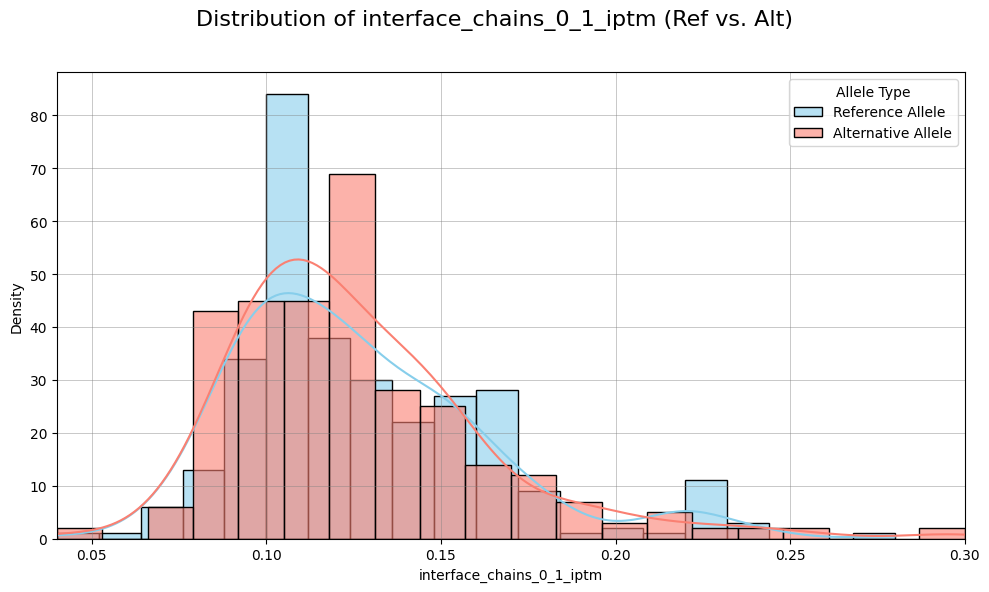

In [38]:
plot_metric_distributions(ref_df, alt_df, 'interface_chains_0_1_iptm','metrics_temp')

In [ ]:
import scipy.stats as stats
def plot_scatter_with_regression(x_list,y_list,x_label,y_label,output_dir="scatter_plots"):

    os.makedirs(output_dir, exist_ok=True)

    x_arr = np.array(x_list, dtype=float)
    y_arr = np.array(y_list, dtype=float)


    x_z = (x_arr - np.mean(x_arr)) / np.std(x_arr)
    y_z = (y_arr - np.mean(y_arr)) / np.std(y_arr)

    z_thresh = 3.0
    inlier_mask = (np.abs(x_z) < z_thresh) & (np.abs(y_z) < z_thresh)
    inlier_mask = (np.abs(x_z) < z_thresh) & (np.abs(y_z) < z_thresh)
    x_inlier = x_arr[inlier_mask]
    y_inlier = y_arr[inlier_mask]


    m, b = np.polyfit(x_arr, y_arr, 1)

    r, p = stats.pearsonr(x_arr, y_arr)


    x_min, x_max = x_inlier.min(), x_inlier.max()
    y_min, y_max = y_inlier.min(), y_inlier.max()

    
    
    if x_min == x_max:
        buffer = abs(x_min) * 0.01 if x_min != 0 else 0.01
        x_min -= buffer
        x_max += buffer

    line_x = np.array([x_min, x_max])
    line_y = m * line_x + b


    fig, ax = plt.subplots(figsize=(8, 6))
    fig.suptitle(f"{y_label} vs. {x_label} Cross-Correlation", fontsize=14)

    ax.scatter(x_arr, y_arr, alpha=0.6, label="Data points",c='red')
    ax.plot(line_x, line_y, color="green", linewidth=2,linestyle='--',
            label=f"Fit: y = {m:.2f}x + {b:.2f},  r = {r:.2f}, p = {p:.2e}")

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xlim(x_min, x_max)
    y_min, y_max = y_arr.min(), y_arr.max()
    if y_min == y_max:
        buf = abs(y_min) * 0.01 if y_min != 0 else 0.01
        ax.set_ylim(y_min - buf, y_max + buf)
    ax.legend(loc="best")
    ax.grid(True, color="gray", alpha=0.6, linewidth=0.5)

    filename = f"{x_label}_vs_{y_label}.png"
    filepath = os.path.join(output_dir, filename)

    fig.savefig(filepath, dpi=300)
    print(f"Saved plot at: {filepath}")


    return filepath

Saved plot at: scatter_plots_temp/ref_interface_ipTM_vs_alt_interface_ipTM.png


'scatter_plots_temp/ref_interface_ipTM_vs_alt_interface_ipTM.png'

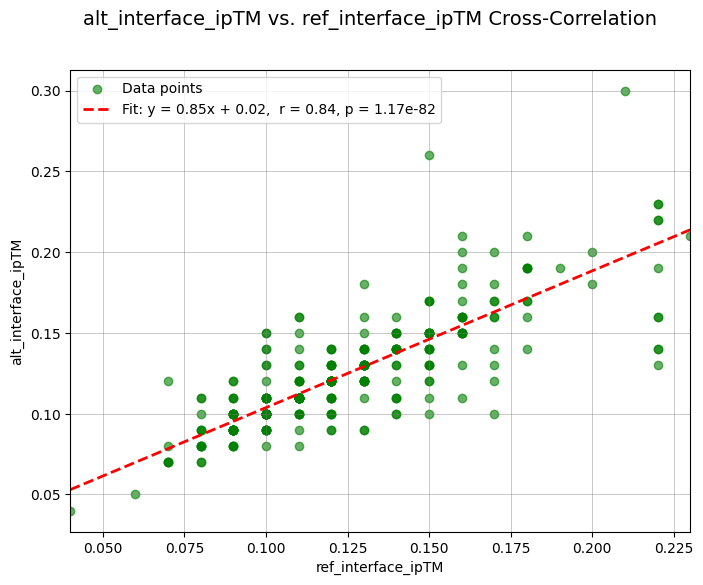

In [41]:
input1 = ref_df['interface_chains_0_1_iptm'].dropna()
input2 = alt_df['interface_chains_0_1_iptm'].dropna()
label1 = 'ref_interface_ipTM'
label2 = 'alt_interface_ipTM'

plot_scatter_with_regression(input1, input2, label1, label2, output_dir="scatter_plots_temp")

Saved plot at: scatter_plots/scatter_ref_chain_0_ptm_vs_alt_chain_0_ptm.png


'scatter_plots/scatter_ref_chain_0_ptm_vs_alt_chain_0_ptm.png'

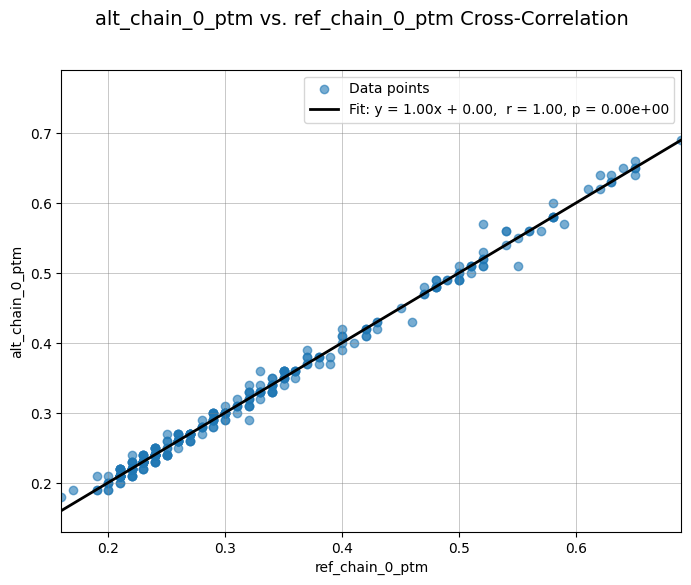

In [11]:
input1 = ref_df['chain_0_ptm'].dropna()
input2 = alt_df['chain_0_ptm'].dropna()
label1 = 'ref_chain_0_ptm'
label2 = 'alt_chain_0_ptm'

plot_scatter_with_regression(input1, input2, label1, label2)

In [22]:
path_to_variants_csv = 'alpha-factor_tf-seq-pairs_complete.csv'
path_to_summary_csv = 'alphafold3_2chain_combined_summary.csv'
path_to_temp_summary_csv = 'alphafold3_notemp_combined_summary.csv'
full_df = create_consolidated_df(path_to_variants_csv, path_to_summary_csv)
full_df_no_temp = create_consolidated_df(path_to_variants_csv, path_to_temp_summary_csv)
ref_df = full_df[full_df['allele_type'] == 'ref'].copy()
alt_df = full_df[full_df['allele_type'] == 'alt'].copy()
ref_df_no_temp = full_df_no_temp[full_df_no_temp['allele_type'] == 'ref'].copy()
alt_df_no_temp = full_df_no_temp[full_df_no_temp['allele_type'] == 'alt'].copy()

ref_df.set_index('snp', inplace=True)
alt_df.set_index('snp', inplace=True)
ref_df_no_temp.set_index('snp', inplace=True)
alt_df_no_temp.set_index('snp', inplace=True)

In [ ]:
d_orig = ref_df['interface_chains_0_1_iptm'] - alt_df['interface_chains_0_1_iptm']
d_temp = ref_df_no_temp['interface_chains_0_1_iptm'] - alt_df_no_temp['interface_chains_0_1_iptm']


In [28]:
#plot_scatter_with_regression(d_orig, d_temp, 'w_template', 'wo_template')